<a href="https://colab.research.google.com/github/giuliaguglielmi123/twitter-sentiment-analysis/blob/main/twitter_comments_clustering_with_hugface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# We will download the twitter dataset from the hugging face HUB

In [18]:
# pip install datasets

## Import Libraries

In [17]:
from datasets import list_datasets

from datasets import load_dataset

import pandas as pd

import matplotlib.pyplot as plt

### Uploaded Hugging-face dataset

In [19]:
all_datasets = list_datasets()

print(f'T\n\nhere are {len(all_datasets)} datasets available in the Hub')
print(f'and the first 10 are: {all_datasets[:10]}')

<ipython-input-19-f4efc8c5980c>:1: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  all_datasets = list_datasets()
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


T

here are 141296 datasets available in the Hub
and the first 10 are: ['acronym_identification', 'ade_corpus_v2', 'UCLNLP/adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'allenai/ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [20]:
# Upload dataset of twitter 'emotion' dataset
emotions = load_dataset('emotion')

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
train_ds = emotions['train']
train_ds # is a Dataset object one of the main datastructured in hugging-face

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [ ]:
print('First row of the dataset:')
print(train_ds[0])
print('----------------------------------------------------------------------------------------------------------------------')
print(f'\n\nColumns names:\n {train_ds.column_names}')
print('----------------------------------------------------------------------------------------------------------------------')
print(f'\n\nFeatures:\n {train_ds.features}')
print('----------------------------------------------------------------------------------------------------------------------')
print(f'\n\nFirst 5 records: \n{train_ds[:5]}')

First row of the dataset:
{'text': 'i didnt feel humiliated', 'label': 0}
----------------------------------------------------------------------------------------------------------------------


Columns names:
 ['text', 'label']
----------------------------------------------------------------------------------------------------------------------


Features:
 {'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}
----------------------------------------------------------------------------------------------------------------------


First 5 records: 
{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}


In [ ]:
emotions.set_format(type='pandas')
df=emotions['train'][:]

In [ ]:
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [ ]:
def label_int2str(row):
  return emotions['train'].features['label'].int2str(row)

In [ ]:
df['label_name'] = df['label'].apply(label_int2str)

In [ ]:
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


## Some statistics

<Axes: ylabel='label_name'>

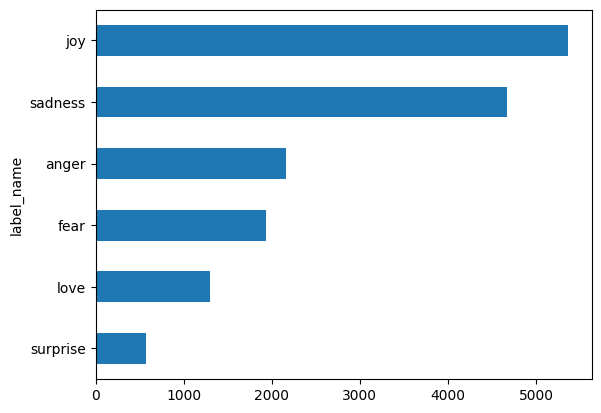

In [ ]:
df['label_name'].value_counts(ascending=True).plot.barh()

In [ ]:
# How long are our tweets?
df['words per tweet'] = df['text'].str.split().apply(len)

<Axes: title={'center': 'words per tweet'}, xlabel='label_name'>

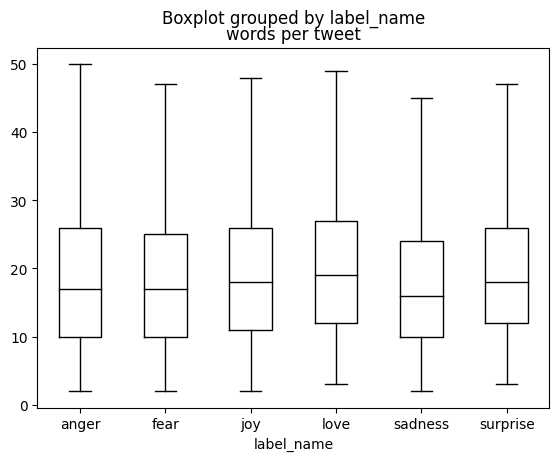

In [ ]:
# for simplicity let's split the tokens into words
df.boxplot('words per tweet', by='label_name', grid=False, showfliers=False, color='black')

# the contetx window of DistilBERT is 512 tokens but, as we can see from the below chart, the maximum length of
# tokens is way below from that limit.

In [ ]:
emotions.reset_format() # reset the format to tokenize our sentences

In [ ]:
# Tokenization:
# splitting into words migth lead to lost of information because it lost the context of information
# whereas splitting into characther will lead into a large vocabulary that will requires neural network s to have an enormous number
# of paramters.
# So the idea is combine the best aspects of characters and work tokenization.

# There are several subwords tokenization algorithms that are commony used in NLP.
# DistilBERT and BERT use WorkPiece tokenizer.

In [ ]:
# AutoTokenizer allows you to load the tokenizer associated to a pretrained model.
from transformers import AutoTokenizer

model_ckpt = 'distilbert-base-uncased'
tokenizer= AutoTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# Example in one record
text = df.copy()
text = text['text'][3]
text = 'famme vede come me converte sta frase nromano ksdfhdc'
print(f'text: \n{text}')

encoded_text = tokenizer(text)
print(f'\n\nWords into numbers: {encoded_text}') # words into numbers
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)

print(f'\n\nTokens: {tokens}')
# CLS: start the sentence
# SEP: at the end of the sentence
# ##: for example 'nostalgic' to highligth that the preciding string is not a white space

text: 
famme vede come me converte sta frase nromano ksdfhdc


Words into numbers: {'input_ids': [101, 6904, 20058, 2310, 3207, 2272, 2033, 10463, 2063, 2358, 2050, 25312, 3366, 17212, 20778, 2080, 29535, 20952, 14945, 2278, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


Tokens: ['[CLS]', 'fa', '##mme', 've', '##de', 'come', 'me', 'convert', '##e', 'st', '##a', 'fra', '##se', 'nr', '##oman', '##o', 'ks', '##df', '##hd', '##c', '[SEP]']


In [ ]:
print(tokenizer)

DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}


## Tokenizing the whole Dataset

In [ ]:
def tokenize(batch):
  """
  params:
  padding: will pad the list with zeros to the size of the longest batch (each batch rapresent a sentece)
  truncation: will truncate the example to the model's maximum context size
  """
  return tokenizer(batch['text'], padding=True, truncation=True)


In [ ]:
print('example:\n\n')
print(emotions['train'][:2])
print('\n\n')
print(tokenize(emotions['train'][:2]))

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


example:


{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake'], 'label': [0, 0]}



{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [ ]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None) # batch_size=None means we will encode the tweets in batches

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
emotions_encoded.set_format(type='pandas')

In [ ]:
emotions_encoded['train'][:]

,text,label,input_ids,attention_mask
0,i didnt feel humiliated,0,"[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,i can go from feeling so hopeless to so damned...,0,"[101, 1045, 2064, 2175, 2013, 3110, 2061, 2062...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,im grabbing a minute to post i feel greedy wrong,3,"[101, 10047, 9775, 1037, 3371, 2000, 2695, 104...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ..."
3,i am ever feeling nostalgic about the fireplac...,2,"[101, 1045, 2572, 2412, 3110, 16839, 9080, 128...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,i am feeling grouchy,3,"[101, 1045, 2572, 3110, 24665, 7140, 11714, 10...","[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...
15995,i just had a very brief time in the beanbag an...,0,"[101, 1045, 2074, 2018, 1037, 2200, 4766, 2051...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
15996,i am now turning and i feel pathetic that i am...,0,"[101, 1045, 2572, 2085, 3810, 1998, 1045, 2514...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
15997,i feel strong and good overall,1,"[101, 1045, 2514, 2844, 1998, 2204, 3452, 102,...","[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ..."
15998,i feel like this was such a rude comment and i...,3,"[101, 1045, 2514, 2066, 2023, 2001, 2107, 1037...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [ ]:
emotions_encoded.reset_format()

## Transformers as Feature Extractors

In [ ]:
# with the Feature Extractors we freeze the weigth, parameters, of the model and use only the hidden states
# as features classifie. The hidden states only need to be precomputed once which is great if you only have a CPU

In [ ]:
from transformers import AutoModel

# !pip install torch
import torch

In [ ]:
model_ckpt='distilbert-base-uncased'

# check whether we've the CPUs
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu') # this ensure that the model will run either on a GPU or CPU
print(f'the device used is {device.type}')
print('\n\n')
model=AutoModel.from_pretrained(model_ckpt).to(device) # with from_pretrained() method we'll load the weights of the model
print('\n\n')
print('weights loaded')

the device used is cpu





model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]




weghts loaded


In [ ]:
text='this is a test'
inputs=tokenizer(text, return_tensors='pt')
print(f'Input tensor shape:\n {inputs["input_ids"].size()}')
print('\n\n')
inputs["input_ids"]

Input tensor shape:
 torch.Size([1, 6])





tensor([[ 101, 2023, 2003, 1037, 3231,  102]])

In [ ]:
inputs={k: v.to(device) for k,v in inputs.items()}

with torch.no_grad():# no_grad() to disable the automatic computation of the gradient
  outputs=model(**inputs)

print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]]), hidden_states=None, attentions=None)


In [ ]:
# get hidden states for one sentecence
print(f'we have {outputs.last_hidden_state.size()[0]} batch\n')
print(f'the batch has {outputs.last_hidden_state.size()[1]} number of tokens\n')
print(f'and each batch has an associated tensor of length {outputs.last_hidden_state.size()[2]}')

we have 1 batch

the batch has 6 number of tokens

and each batch has an associated tensor of length 768


In [ ]:
# Let's do the same for the entire dataset
def extract_hidden_states(batch):
  # Place model inputs on the GPU or CPU
  inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
  # Extract last hidden states
  with torch.no_grad():
    last_hidden_state=model(**inputs).last_hidden_state
  # return vector for [CLS] token
  return {'hidden_state': last_hidden_state[:,0].cpu().numpy()}

In [ ]:
emotions_encoded.set_format('torch', columns=['label', 'input_ids', 'attention_mask'])

In [ ]:
emotions_hidden=emotions_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
import numpy as np

In [ ]:
X_train=np.array(emotions_hidden['train']['hidden_state'])
X_valid=np.array(emotions_hidden['validation']['hidden_state'])
y_train=np.array(emotions_hidden['train']['label'])
y_valid=np.array(emotions_hidden['validation']['label'])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

In [ ]:
# pip install umap
# !pip install bertopic
# import umap.umap_ as UMAP
# pip install -U umap-learn

In [ ]:
## Visualizing the training set
from umap.umap_ import UMAP
from sklearn.preprocessing import MinMaxScaler
import pandas as pd  # Ensure pandas is imported

# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)

# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric='cosine').fit(X_scaled)

# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=['X', 'Y'])
df_emb['label'] = y_train
print(df_emb.head())


          X         Y  label
0  4.091444  6.570541      0
1 -3.310446  6.212828      0
2  4.894875  3.063905      3
3 -2.906096  4.036428      2
4 -3.716331  4.145695      3


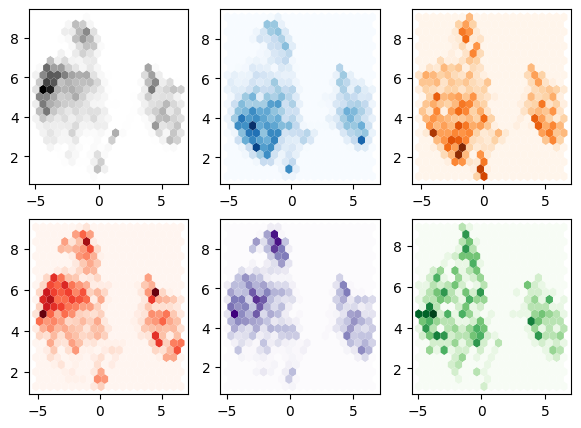

In [ ]:
fig, axes=plt.subplots(2, 3, figsize=(7,5))
axes=axes.flatten()
cmaps=['Greys', 'Blues', 'Oranges', 'Reds', 'Purples', 'Greens']
labels=emotions['train'].features['label'].names

for i, (labels, cmap) in enumerate(zip(labels, cmaps)):
  df_emb_sub=df_emb.query(f'label=={i}')
  axes[i].hexbin(df_emb_sub['X'], df_emb_sub['Y'], cmap=cmap, gridsize=20, linewidths=(0,))

## Training a simple classifier

In [ ]:
from sklearn.linear_model import LogisticRegression
# We increse max_iter to guarantee convergence
lr_clf=LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.6335

### Confusion matrix

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
def plot_confusion_matrix(y_pred,y_true,labels):
  cm=confusion_matrix(y_true,y_pred, normalize='true')
  flg,ax=plt.subplots(figsize=(6,6))
  disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap='Blues', values_format='.2f',ax=ax, colorbar=False)
  plt.title('Normalized confusion matrix')
  plt.show()

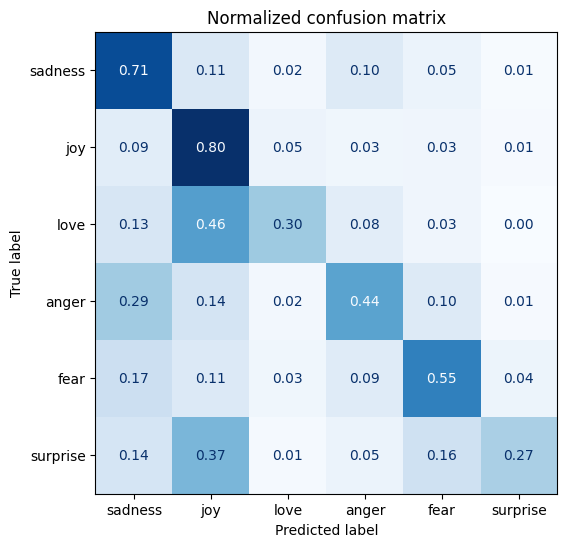

In [ ]:
y_preds=lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds,y_valid,labels)